In [283]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [284]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [285]:
len(words)

32033

In [286]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [287]:
block_size = 3 # context length: how many characters do we take to predict the next one?

In [288]:
# build the dataset
def build_dataset(words, label=''):
  X, Y = [], [] # inputs, labels
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append (rolling window of context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(label, X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1], label='train')
X_val, Y_val = build_dataset(words[n1:n2], label='validation')
X_test, Y_test = build_dataset(words[n2:], label='test')

train torch.Size([182625, 3]) torch.Size([182625])
validation torch.Size([22655, 3]) torch.Size([22655])
test torch.Size([22866, 3]) torch.Size([22866])


In [289]:
# dataset
X_train.shape, Y_train.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [291]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# build the embedding lookup table, C
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2] # cluster parameters into single list for interpretability

In [292]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [293]:
for p in parameters:
  p.requires_grad = True

In [294]:
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10**lre

In [295]:
lri = []
lossi = []
stepi = []

In [296]:
# training loop
for i in range(200_000):
  # minibatch construction
  ix = torch.randint(0, X_train.shape[0], (32,))

  # forward pass
  emb = C[X_train[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix]) # preferred over hand rolled implementation due to PyTorch kernel fusion, other memory optimizations, etc.
  # print(f'loss={loss.item()}')
  
  # backward pass
  for p in parameters:
    p.grad = None
  
  loss.backward()

  # parameter update
  # learning_rate = lrs[i]
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

In [297]:
loss.item()

2.131345748901367

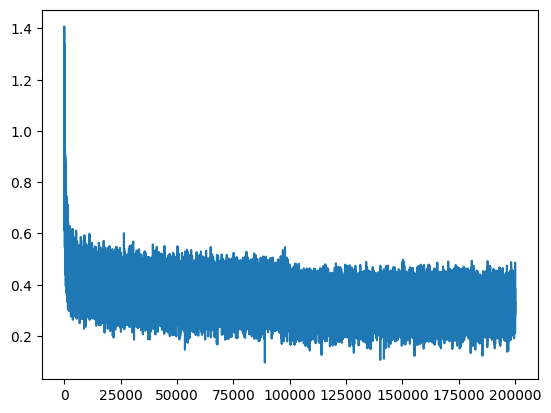

In [298]:
# visualize learning rates relative to loss to determine optimal learning rate for model
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)

In [299]:
# loss on test set
emb = C[X_test]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
loss

tensor(2.1708, grad_fn=<NllLossBackward0>)

In [300]:
# loss on validation set
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.1800, grad_fn=<NllLossBackward0>)

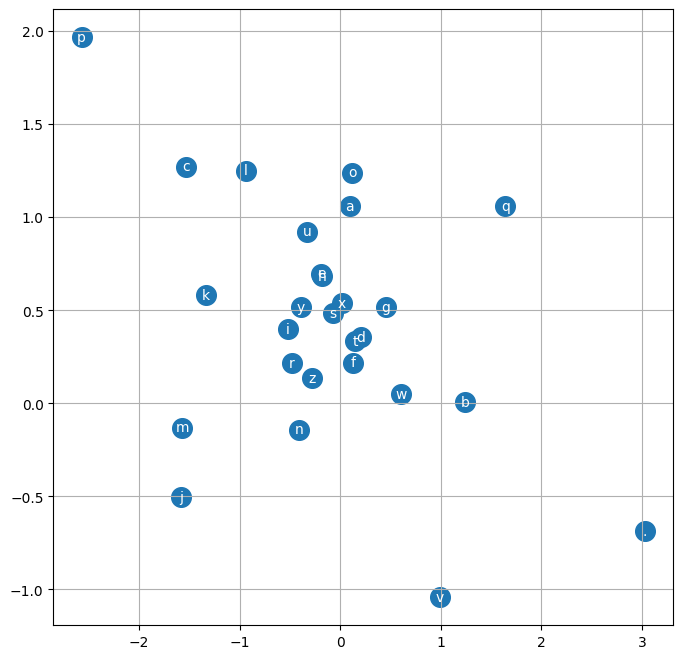

In [301]:
# visualize the embeddings, typically done while small since after scaling these become almost
# impossible to interpret
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# After the small amount of training, and with a small embedding size, we can see that clustering
# is already starting to occur. Specifically we can see that vowels are clustering which intuitively
# makes sense in the English language

In [302]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all '...'
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

carpatela.
jhavi.
kemri.
reyty.
skandane.
mahuth.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
pois.
quinn.
shlin.
ania.
bick.
jeron.
jaryni.
jace.


training split, dev/validation split, test split

`(80%, 10%, 10%)`

train parameters, train hyperparameters, evaluate model perf

Only allowed to evaluate the test split very few times because each time you evaluate
the test split you are learning about your targets and you risk overfitting to the test split

When loss on the validation split and the test split are roughly the same this means two things

1. The model is underfitting, not memorizing the dataset
2. The network is very small, expect to make improvements in perf with scaling

When scaling the parameters of the neural network, we should see a decreased loss.
Optimizing the parameter layers of the neural network is the real game of building
a well performing neural network.

- Improve the input layer (embedding layer) by optimizing the dimensional reduction to allow for
  more input features. You could improve
- Improve the hidden layer with more or less parameters
- Improve the optimization layer by choosing a different optimization function (softmax, etc.)

In production, to find the optimal learning rate (learning rate decay) you would create hyper
parameters of all the settings, run lots of experiments and see which hyper parameters give
you the best validation split performance. You then take this model and evaluate the test split
performance a single time and this is the number you report in some kind of publication.

#### Exercise

To further improve the loss of the model there are a couple of nobs that can be tweaked:

1. Change the number of neurons in the hidden layer
2. Change the dimensionality of the embedding lookup table
3. Change the number of characters that are feeding in as an input (context) into the model
4. Change the details of the optimization
  - How long (steps) is the model running for?
  - What is the learning rate? How does it change over time? How does it decay?
  - Change the batch size

A good measuring stick is how quickly the model converges to a lower loss